# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB


In [2]:
# прочитаем данные
data = pd.read_csv('data/spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [79]:
# рассчитаем частоты для классов
print(data.groupby('label').count()) # количество по классам
print()
print(round(data['label'].value_counts(normalize=True)*100, 2)) # процентное соотношение

       email
label       
0       2500
1        497

0    83.42
1    16.58
Name: label, dtype: float64


Text(0, 0.5, 'Count')

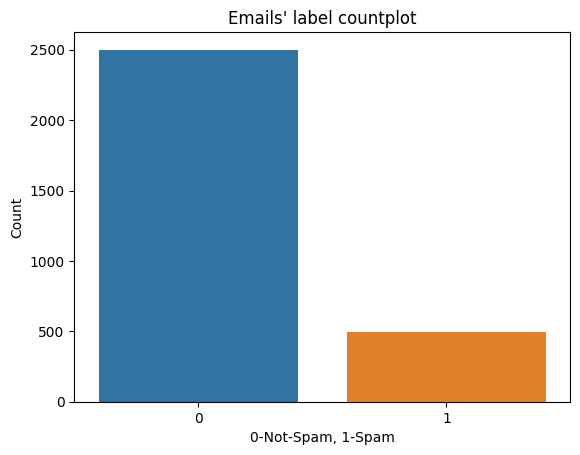

In [63]:
# визуализируем результат
labels = sns.countplot(data, x='label' )
labels.set_title("Emails' label countplot")
labels.set_xlabel('0-Not-Spam, 1-Spam')
labels.set_ylabel('Count')


Видно, что классы весьма несбалансированы, следует это учесть при разбиении выборки.

## Задание 2 (2 балла)

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
data['email'] = data['email'].replace(r'^\s\*$', np.nan, regex=True)
data['email'] = data['email'].replace(r'^\s+$', np.nan, regex=True)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2997 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2997 non-null   object
 1   label   2997 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.2+ KB


Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
# целевая переменная
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
# разбиваем выборку со стратификацией по таргету
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [80]:
print(round(y_test.mean(), 3))

0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [19]:
# применим алгоритмы, предназначенные для работы с текстом
MNB = MultinomialNB(alpha=0.01)
MNB.fit(X_train, y_train)
y_MNB_pred = MNB.predict(X_test)

CNB = ComplementNB(alpha=0.01)
CNB.fit(X_train, y_train)
y_CNB_pred = CNB.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [68]:
# посчитаем метрики для обеих моделей
print('MultinomialNB')
print('Accuracy:', round(accuracy_score(y_test, y_MNB_pred), 3),\
    'Precision:',round(precision_score(y_test, y_MNB_pred), 3), \
        'F1 score:',round(f1_score(y_test, y_MNB_pred), 3))
print()
print(classification_report(y_test, y_MNB_pred))
print()
print('ComplementNB')
print('Accuracy:',round(accuracy_score(y_test, y_CNB_pred), 3),\
    'Precision:', round(precision_score(y_test, y_CNB_pred), 3),\
        'F1 score', round(f1_score(y_test, y_CNB_pred), 3))
print()
print(classification_report(y_test, y_CNB_pred))


MultinomialNB
Accuracy: 0.987 Precision: 1.0 F1 score: 0.958

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       626
           1       1.00      0.92      0.96       124

    accuracy                           0.99       750
   macro avg       0.99      0.96      0.98       750
weighted avg       0.99      0.99      0.99       750


ComplementNB
Accuracy: 0.988 Precision: 1.0 F1 score 0.962

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       626
           1       1.00      0.93      0.96       124

    accuracy                           0.99       750
   macro avg       0.99      0.96      0.98       750
weighted avg       0.99      0.99      0.99       750



Мы видим, что ComplementNB справилась чуть лучше. В целом, результат работы обеих моделей очень хороший, судя по метрикам.

Нарисуйте ROC-кривую:

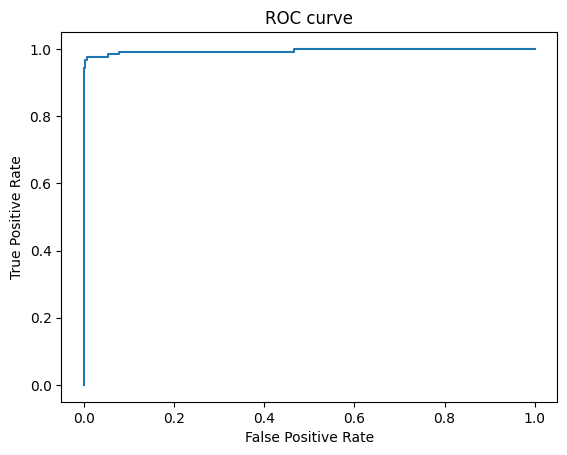

AUC: 0.9950659589817583


In [81]:
# построим roc кривую для более успешной модели ComplementNB
y_pred_proba = CNB.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score (y_test, y_pred_proba)

plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show() 
print('AUC:', auc)

Кривая и показатель AUC говорят о высоком качестве модели, которая с вероятностью 99,5% верно предсказывает тип письма.

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [71]:
param_distributions = {'alpha':[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 10]},
# Создаем объект класса           
random_search = RandomizedSearchCV(
    estimator=ComplementNB(), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
# Обучаем, предсказываем и вычисляем метрику
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 281 ms
Wall time: 4.7 s
f1_score на тестовом наборе: 0.98
Наилучшие значения гиперпараметров: {'alpha': 0.7}


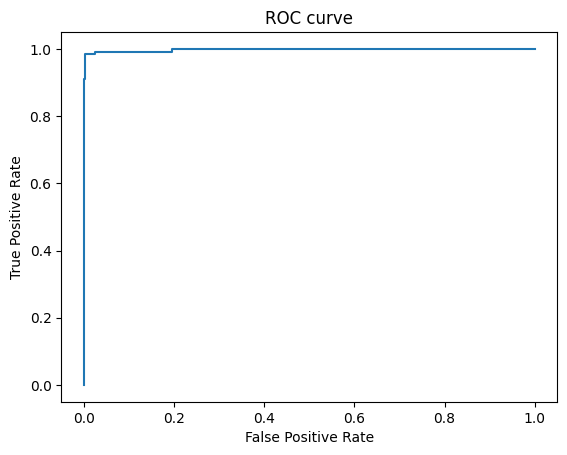

AUC: 0.9981062557971762


In [83]:
CNB_new = ComplementNB(alpha=0.7)
CNB_new.fit(X_train, y_train)

y_pred_proba = CNB_new.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score (y_test, y_pred_proba)

plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show() 
print('AUC:', auc)

С помощью подбора гиперпараметров удалось найти значение alpha=0.7, при котором качество классификации удалось улучшить до вероятности точного прогноза 99,8%